# Задача
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

<b>Флэшмоб проходил с 2024-07-12 по 2024-07-18. Ваша задача как аналитика – оценить эффективность этого мероприятия.</b>

1) Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.
2) Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.
3) Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы и аргументируйте их.

Формат сдачи задания – merge request в GitLab с ноутбуком, где выполнены вычисления (формат .ipynb).

## Подгружаем библиотеки

In [3]:
import pandas as pd
import pandahouse
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
import arviz as az

from orbit.eda import eda_plot
from orbit.diagnostics.backtest import BackTester #основной класс для бэктестинга 
from orbit.utils.params_tuning import grid_search_orbit #для подбора оптимальных параметров
from orbit.diagnostics.metrics import rmsse

from causalimpact import CausalImpact

2024-08-08 14:38:08.108439: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-08 14:38:08.996966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
'database':'simulator_20240720',
'user':'student',
'password':'dpo_python_2020'
}

In [5]:
q = '''
with tab1 as (
    SELECT 
        date,
        count(post_id) new_posts
    FROM
        (SELECT
            post_id,
            min(toDate(time)) date
        FROM simulator_20240720.feed_actions
        GROUP BY post_id)
    GROUP BY date),
tab2 as (
    SELECT
        toDate(time) date,
        uniq(user_id) users,
        countIf(action=='view') views,
        countIf(action=='like') likes,
        likes/views ctr
    FROM simulator_20240720.feed_actions fa
    GROUP BY date)
SELECT
    date,
    users,
    views,
    likes,
    ctr,
    new_posts
FROM tab2
LEFT JOIN tab1
USING date
'''

In [6]:
df = pandahouse.read_clickhouse(q, connection=connection)

In [7]:
df.head(10)

,date,users,views,likes,ctr,new_posts
0,2024-06-01,878,7603,1560,0.205182,89
1,2024-06-02,2238,62770,12816,0.204174,97
2,2024-06-03,3105,105526,20958,0.198605,61
3,2024-06-04,3721,118996,23800,0.200007,87
4,2024-06-05,4617,174454,34504,0.197783,70
5,2024-06-06,4728,168419,33604,0.199526,76
6,2024-06-07,4890,184971,37604,0.203297,92
7,2024-06-08,5878,231423,46308,0.200101,61
8,2024-06-09,6771,240955,48414,0.200925,92
9,2024-06-10,7667,324429,64790,0.199705,77


## Задача 1 
Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите хотя бы 5 метрик.

1) Количество новых постов. По сути флешмоб стимулирует людей писать больше постов, так что можно ожидать, что количество новых постов в период флешмоба вырастет.
2) Количество лайков. Скорее всего люди будут стимулировать других пользователей поставить лайк к их посту.
3) CTR. Опять-таки, из-за того, что люди скорее всего будут стимулировать других людей ставить лайки к их постам, ctr может вырасти.
4) DAU. Флешмоб скорее всего должен стимулировать людей больше заходить в соц сеть, как креаторов, так и "потребителей".
5) Количество просмотров. Скорее всего увеличение количества постов должен вызвать увеличение этой метрики.

## Задача 2
Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.

### Количество новых постов во время флешмоба

<Axes: xlabel='date', ylabel='new_posts'>

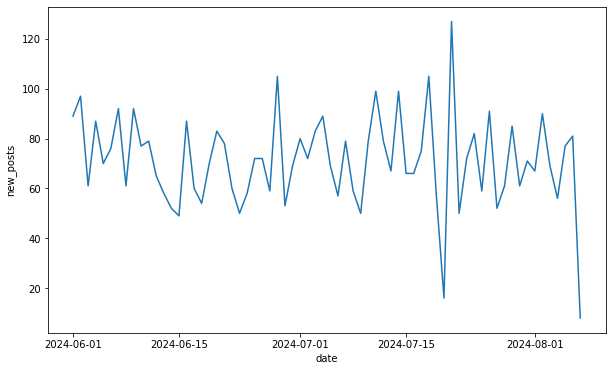

In [6]:
plt.figure(figsize=(10, 6)) # размер окна графика
sns.lineplot(df, x='date', y='new_posts')

Пока что сложно говорить об увеличении количества новых постов

In [7]:
df = df.set_index(df.date).drop(columns=['date'])
df

,users,views,likes,ctr,new_posts
date,,,,,
2024-06-01,878,7603,1560,0.205182,89
2024-06-02,2238,62770,12816,0.204174,97
2024-06-03,3105,105526,20958,0.198605,61
2024-06-04,3721,118996,23800,0.200007,87
2024-06-05,4617,174454,34504,0.197783,70
...,...,...,...,...,...
2024-08-03,19554,833754,182190,0.218518,69
2024-08-04,19572,744881,164565,0.220928,56
2024-08-05,19768,710587,154251,0.217075,77


In [8]:
impact_posts = CausalImpact(df['new_posts'], #данные
                      pre_period = [df.index.min(), '2024-07-11'], #период до события
                      post_period = [ '2024-07-12', '2024-07-18'], #период после события
                      #model, #можно задать свою модель, а не пользоваться моделью по умолчанию
                      #model_args, #аргументы модели - см. docstring функции
                      #alpha #уровень значимости
                     )

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2024-08-07 13:13:27.804580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-08-07 13:13:27.804817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-08-07 13:13:27.811695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [1]
	 [[{{node shape}}]]
2024-08-07 13:13:27.811875: I tens

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`


2024-08-07 13:13:28.010968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:28.036288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:28.582954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


2024-08-07 13:13:38.470946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-08-07 13:13:38.529968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

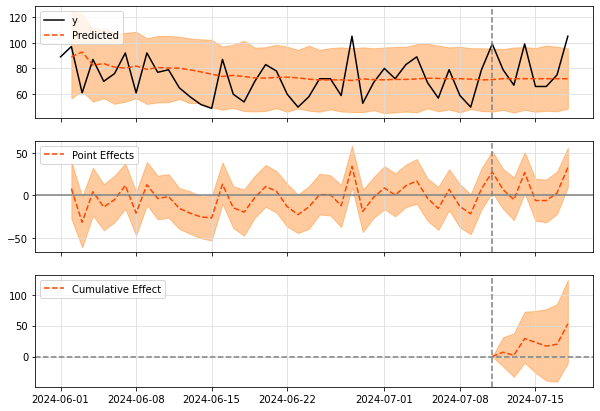

In [9]:
impact_posts.plot()

In [10]:
print(impact_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         72.03 (5.13)       504.2 (35.92)
95% CI                    [62.39, 82.51]     [436.75, 577.54]

Absolute effect (s.d.)    7.54 (5.13)        52.8 (35.92)
95% CI                    [-2.93, 17.18]     [-20.54, 120.25]

Relative effect (s.d.)    10.47% (7.12%)     10.47% (7.12%)
95% CI                    [-4.07%, 23.85%]   [-4.07%, 23.85%]

Posterior tail-area probability p: 0.07
Posterior prob. of a causal effect: 92.51%

For more details run the command: print(impact.summary('report'))


In [11]:
print(impact_posts.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 79.57. In the absence of an
intervention, we would have expected an average response of 72.03.
The 95% interval of this counterfactual prediction is [62.39, 82.51].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 7.54 with a 95% interval of
[-2.93, 17.18]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 557.0.
Had the intervention not taken place, we would have expected
a sum of 504.2. The 95% interval of this prediction is [436.75, 577.54].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an increase of +10.

#### Вывод

Видно, что количество новых постов в период проведения акции действительно увеличилось. Среднее количество постов увеличилось на 7.55 или на 10%.

Но стоит отметить, что эти данные не являются статистически значимыми p_value 5,69% при уровне стат значимости 5%.

### Количество лайков.

In [12]:
impact_likes = CausalImpact(df['likes'], #данные
                      pre_period = [df.index.min(), '2024-07-11'], #период до события
                      post_period = [ '2024-07-12', '2024-07-18'], #период после события
                      #model, #можно задать свою модель, а не пользоваться моделью по умолчанию
                      #model_args, #аргументы модели - см. docstring функции
                      #alpha #уровень значимости
                     )

2024-08-07 13:13:40.205935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:40.224635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:40.609251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:

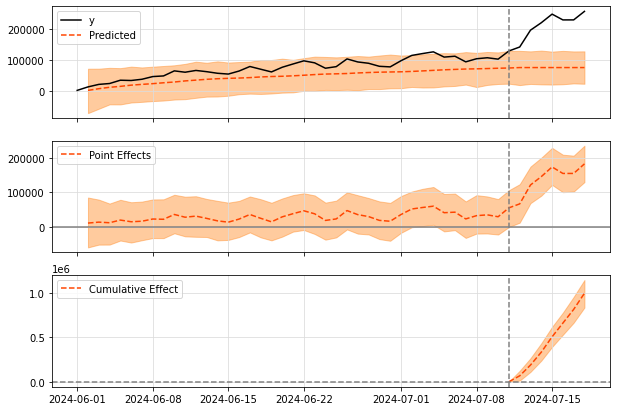

In [13]:
impact_likes.plot()

In [14]:
print(impact_likes.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    218090.14          1526631.0
Prediction (s.d.)         75535.21 (11294.62)528746.5 (79062.36)
95% CI                    [53160.78, 97434.9][372125.49, 682044.31]

Absolute effect (s.d.)    142554.94 (11294.62)997884.5 (79062.36)
95% CI                    [120655.24, 164929.36][844586.69, 1154505.51]

Relative effect (s.d.)    188.73% (14.95%)   188.73% (14.95%)
95% CI                    [159.73%, 218.35%] [159.73%, 218.35%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [15]:
print(impact_likes.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 218090.14. By contrast, in the absence of an
intervention, we would have expected an average response of 75535.21.
The 95% interval of this counterfactual prediction is [53160.78, 97434.9].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 142554.94 with a 95% interval of
[120655.24, 164929.36]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1526631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 528746.5. The 95% interval of this prediction is [372125.49, 682044.31].


The above results are given in terms of absolute numbers. In 

#### Вывод

~~Божечки кошечки~~ Судя по нашему тесту, флешмоб действительно повлиял на количество лайков. В среднем из количество выросло на 142020 или на +186.7%

К тому же, это изменение имеет статзначимость, так что можно утверждать, что флешмоб позитивно повлиял на количество лайков.

### CTR

<Axes: xlabel='date', ylabel='ctr'>

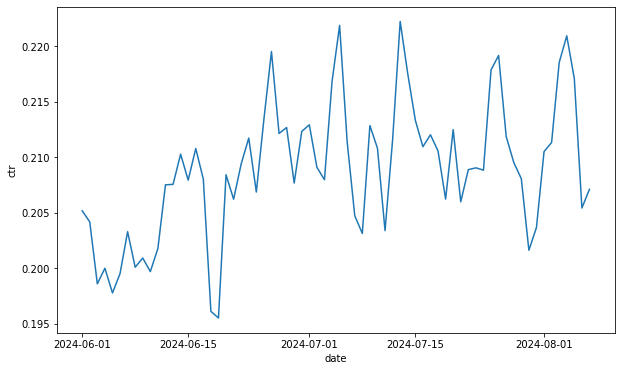

In [16]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x=df.index, y='ctr')

In [17]:
impact_ctr = CausalImpact(df['ctr'], #данные
                      pre_period = [df.index.min(), '2024-07-11'], #период до события
                      post_period = [ '2024-07-12', '2024-07-18'], #период после события
                      #model, #можно задать свою модель, а не пользоваться моделью по умолчанию
                      #model_args, #аргументы модели - см. docstring функции
                      #alpha #уровень значимости
                     )

2024-08-07 13:13:51.968939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:51.986134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:13:52.363117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:

2024-08-07 13:14:01.866403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-08-07 13:14:01.930077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

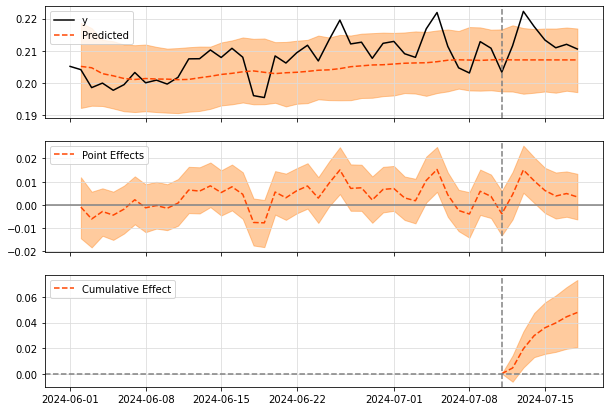

In [18]:
impact_ctr.plot()

In [19]:
print(impact_ctr.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.01)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.01)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.3% (1.0%)        3.3% (1.0%)
95% CI                    [1.45%, 5.38%]     [1.45%, 5.38%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [20]:
print(impact_ctr.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 0.21. By contrast, in the absence of an
intervention, we would have expected an average response of 0.21.
The 95% interval of this counterfactual prediction is [0.2, 0.21].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 0.01 with a 95% interval of
[0.0, 0.01]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 1.5.
By contrast, had the intervention not taken place, we would have expected
a sum of 1.45. The 95% interval of this prediction is [1.42, 1.48].


The above results are given in terms of absolute numbers. In relative
terms, the response variable showed an incre

#### Вывод

~~Божечки кошечки 2~~ средний ctr вырос на 3.3%. И этот эффект, можно считать стат значимым

### DAU

In [21]:
impact_dau = CausalImpact(df['users'], #данные
                      pre_period = [df.index.min(), '2024-07-11'], #период до события
                      post_period = [ '2024-07-12', '2024-07-18'], #период после события
                      #model, #можно задать свою модель, а не пользоваться моделью по умолчанию
                      #model_args, #аргументы модели - см. docstring функции
                      #alpha #уровень значимости
                     )

2024-08-07 13:14:03.478444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:14:03.500971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:14:03.923114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:

In [22]:
print(impact_dau.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         15004.82 (1068.85) 105033.77 (7481.96)
95% CI                    [12807.05, 16996.88][89649.37, 118978.13]

Absolute effect (s.d.)    1047.89 (1068.85)  7335.23 (7481.96)
95% CI                    [-944.16, 3245.66] [-6609.13, 22719.63]

Relative effect (s.d.)    6.98% (7.12%)      6.98% (7.12%)
95% CI                    [-6.29%, 21.63%]   [-6.29%, 21.63%]

Posterior tail-area probability p: 0.16
Posterior prob. of a causal effect: 84.42%

For more details run the command: print(impact.summary('report'))


In [23]:
print(impact_dau.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 16052.71. In the absence of an
intervention, we would have expected an average response of 15004.82.
The 95% interval of this counterfactual prediction is [12807.05, 16996.88].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 1047.89 with a 95% interval of
[-944.16, 3245.66]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 112369.0.
Had the intervention not taken place, we would have expected
a sum of 105033.77. The 95% interval of this prediction is [89649.37, 118978.13].


The above results are given in terms of absolute numbers. In relative
terms, the response vari

#### DAU

Судя по нашему тесту, DAU во время проведения аакции выросло на 1039 пользователей или на 6.39%. 

Но также отметим, что этот результат не является стат значимым. Так что у нас нет причин полагать, что этот результат закономерен, а не является случайностью

### Просмотры постов.

In [24]:
impact_views = CausalImpact(df['views'], #данные
                      pre_period = [df.index.min(), '2024-07-11'], #период до события
                      post_period = [ '2024-07-12', '2024-07-18'], #период после события
                      #model, #можно задать свою модель, а не пользоваться моделью по умолчанию
                      #model_args, #аргументы модели - см. docstring функции
                      #alpha #уровень значимости
                     )

2024-08-07 13:14:14.807912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:14:14.827180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma/sample_1/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:14:15.235252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: No function library is provided.
	 [[{{node powerInverseGamma_CONSTRUCTED_AT_joint_log_prob/sample/InverseGamma/sample/PartitionedCall}}]]
2024-08-07 13:

2024-08-07 13:14:24.832379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2024-08-07 13:14:24.886782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

In [25]:
print(impact_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         363335.75 (50550.33)2543350.25 (353852.34)
95% CI                    [266343.88, 464497.59][1864407.15, 3251483.14]

Absolute effect (s.d.)    656611.56 (50550.33)4596281.0 (353852.34)
95% CI                    [555449.73, 753603.43][3888147.86, 5275223.85]

Relative effect (s.d.)    180.72% (13.91%)   180.72% (13.91%)
95% CI                    [152.88%, 207.41%] [152.88%, 207.41%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


In [26]:
print(impact_views.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 1019947.31. By contrast, in the absence of an
intervention, we would have expected an average response of 363335.75.
The 95% interval of this counterfactual prediction is [266343.88, 464497.59].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is 656611.56 with a 95% interval of
[555449.73, 753603.43]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 7139631.0.
By contrast, had the intervention not taken place, we would have expected
a sum of 2543350.25. The 95% interval of this prediction is [1864407.15, 3251483.14].


The above results are given in terms of absolute num

#### Вывод

Количество просмотров выросло на 7139631 или на 180%. 

Результат является стат значимым, так что у нас есть основания пологать, что этот результат не случаен

## Задача 3

Имел ли флэшмоб какие-то долгосрочные эффекты? Сделайте выводы и аргументируйте их.

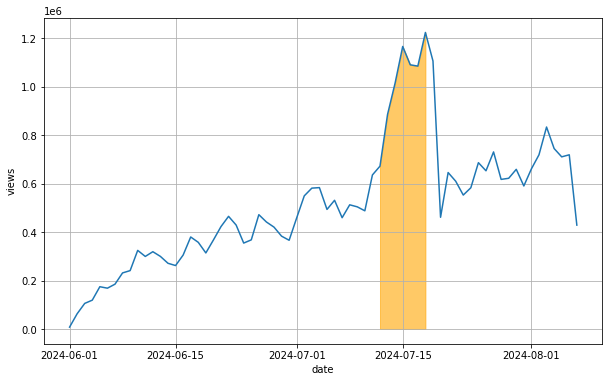

In [27]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='views')
plt.fill_between(df.index, df['views'], where=(df.index >= '2024-07-12') & (df.index <= '2024-07-18'), 
                 color='orange', alpha=0.6)
plt.grid()

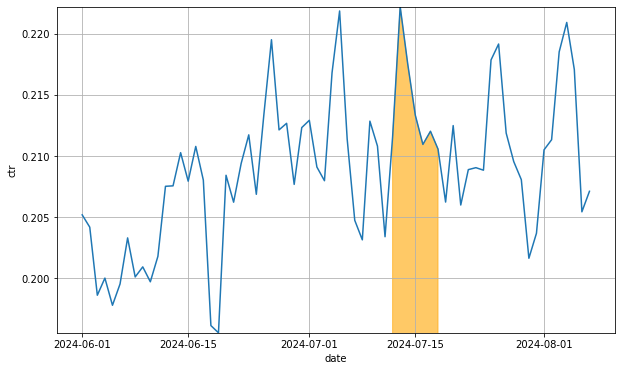

In [28]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='ctr')
plt.fill_between(df.index, df['ctr'], where=(df.index >= '2024-07-12') & (df.index <= '2024-07-18'), 
                 color='orange', alpha=0.6)
plt.ylim(df.ctr.min(), df.ctr.max())
plt.grid()

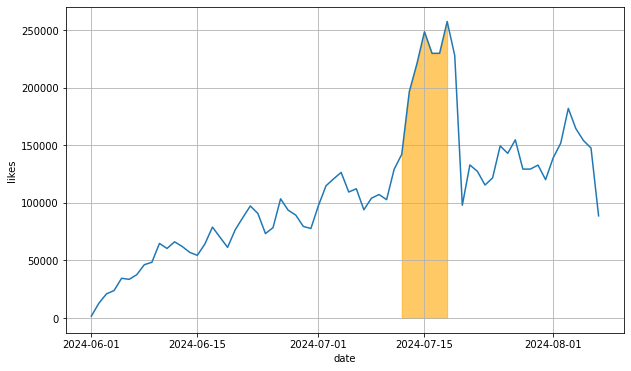

In [29]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='likes')
plt.fill_between(df.index, df['likes'], where=(df.index >= '2024-07-12') & (df.index <= '2024-07-18'), 
                 color='orange', alpha=0.6)
plt.grid()

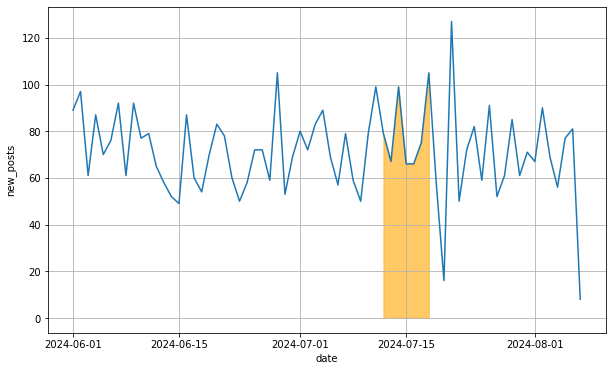

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='new_posts')
plt.fill_between(df.index, df['new_posts'], where=(df.index >= '2024-07-12') & (df.index <= '2024-07-18'), 
                 color='orange', alpha=0.6)
plt.grid()

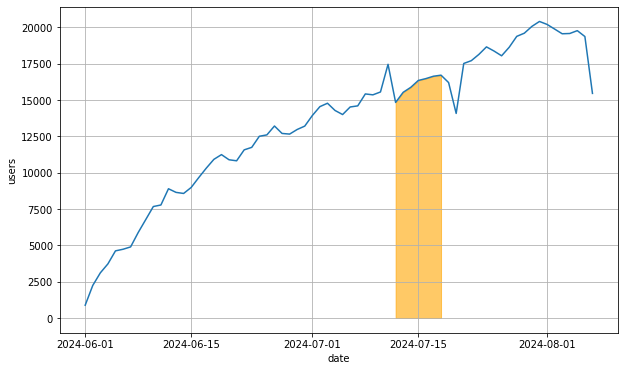

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='users')
plt.fill_between(df.index, df['users'], where=(df.index >= '2024-07-12') & (df.index <= '2024-07-18'), 
                 color='orange', alpha=0.6)
plt.grid()

### Вывод

Прошло не так много времени, чтобы делать какие-то выводы. 

Но если посмотреть визуально на наши метрики, то можно увидеть, что в целом тренд не сильно изменился. За резким всплеском в период акции следовал резкий спад и возвращение к нормальным показателям

А стр и новые посты в целом не сильно отреагировали на мероприятие.